# Heuristic Models 

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from error_metrics import smape, mase

### Defining the Trained, Validation and Tested Data Set from Hourly Set

In [2]:
# Importing the trained and tested values
df_train = pd.read_csv("Hourly_wdates.csv", index_col=0)
df_test = pd.read_csv("Hourly-test.csv", index_col=0)

# Defining n as the Time Series example
n = 257 #250, 220
        # 100

# Dropping NA values and using only positive values
df = df_train.iloc[n - 1, 2:].dropna()
df = df[df > 0]
df = pd.to_numeric(df, errors='coerce')

# We use the initial value and set it to the first obersvation and then adding an hour to next observations
initial_date = df_train.iloc[n - 1, 0]
index = pd.date_range(start=initial_date, periods=len(df), freq='h')
df.index = index

# Doing the same for tested valeus, just using the last date of the trained set
tested = df_test.iloc[n - 1, :].dropna()
tested = tested[tested > 0]
tested = pd.to_numeric(tested, errors='coerce')

last_date_train = df.index[-1]
index_test = pd.date_range(start=last_date_train  + pd.Timedelta(hours=1) , periods=len(tested), freq='h')
tested.index = index_test

# Splitting into training and validation sets
validation_size = 48  
train_df = df.iloc[:-validation_size]  
val_df = df.iloc[-validation_size:] 

#### At the end we have the data as follow

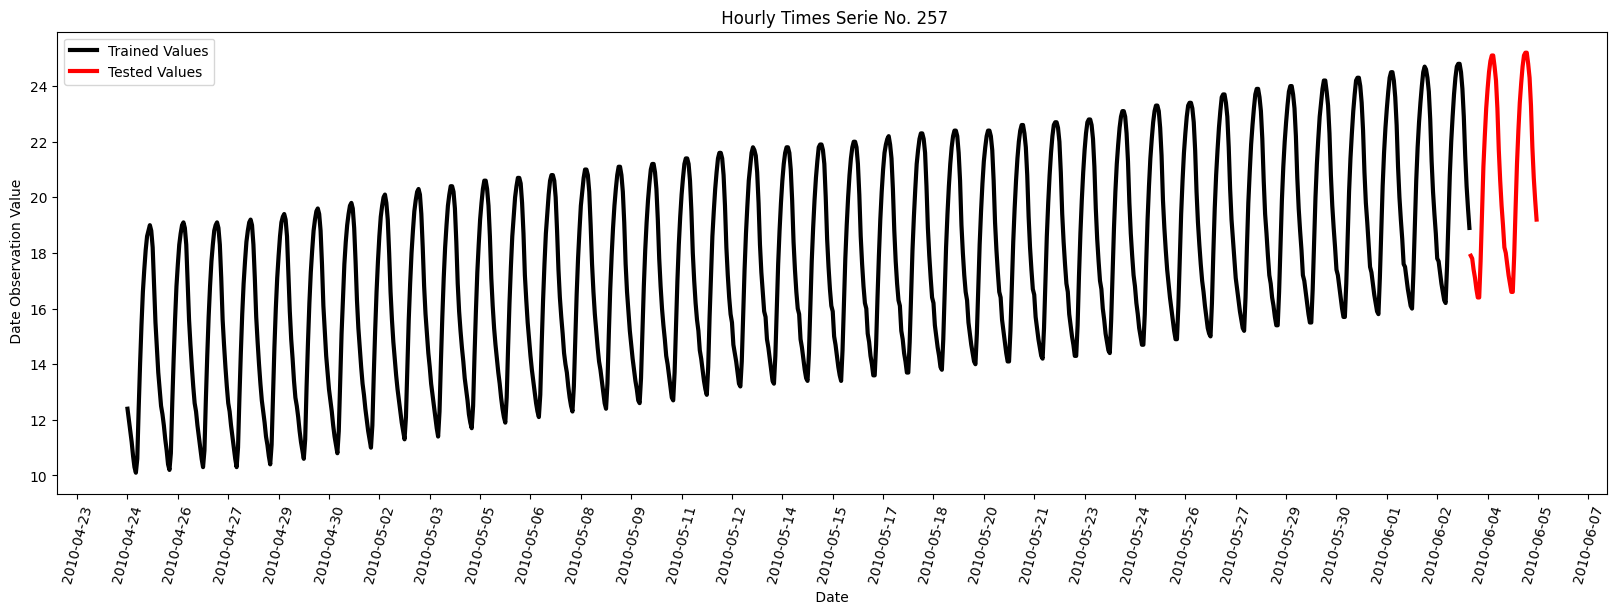

In [3]:
# Plot original data
h = 48
plt.figure(figsize=(20, 6))
plt.plot(df.index,df, color = "black",label='Trained Values',lw = 3)
#plt.plot(val_df.index,val_df,label='Validation Values', color = "red",lw = 3)
plt.plot(tested[:h].index,tested[:h],label='Tested Values', color = "red",lw = 3)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))
plt.xticks(rotation= 75)  
plt.title(f" Hourly Times Serie No. {n}")
plt.xlabel(" Date ")
plt.ylabel(" Date Observation Value")
plt.legend()
plt.show()

## Models

### Heuristic Models

#### - Triple Exponential Smoothing (Holt-Winters)
#### - Seasonal Moving Average
#### - Seasonal Naive Method

### Triple Exponential Smoothing

In [4]:
from heuristic_models import holt_winters

# Hyperparameters
alpha = 0.1
beta = 0.1
gamma = 0.1
seasonal_periods = 24  # Since we are working with Hourly data, the frequency is 24

h = 48 # Numbers asked horizons

holt_winters_forecast = holt_winters(df,tested, alpha= alpha, beta= beta, gamma = gamma, seasonal_periods= seasonal_periods, horizons= h)

### Seasonal Averaging Method

In [5]:
from heuristic_models import seasonal_averaging_forecast

sea_average_forecast = seasonal_averaging_forecast(df,tested[:h])

### Seasonal Naive Method

In [6]:
from heuristic_models import seasonal_naive_forecast

naive_forecast = seasonal_naive_forecast(df,tested[:h])

### Plot of the of the Training and Validation Values for Evaluation

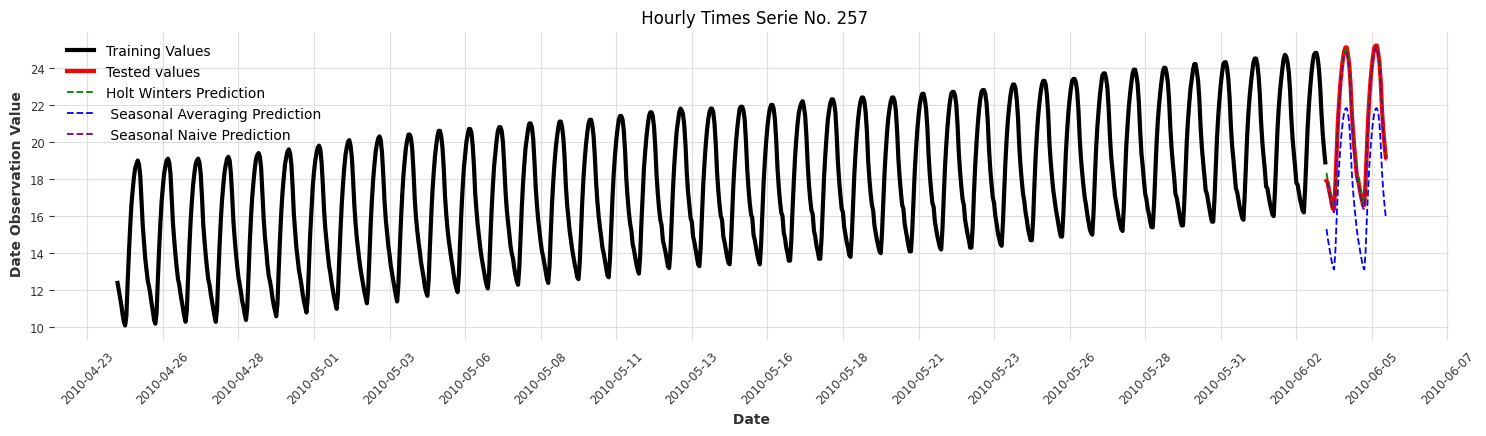

In [7]:
# Plot forecast
plt.figure(figsize=(18, 4))
plt.plot(df.index,df,color = "black", label='Training Values',lw = 3)
plt.plot(tested[:h].index, tested[:h], color='red', label = "Tested values",lw = 3)

# Holt Winters Predition
plt.plot(holt_winters_forecast.index, holt_winters_forecast, color='green', label = "Holt Winters Prediction", linestyle = "--")
# Seasonal Averaging Predition
plt.plot(sea_average_forecast.index, sea_average_forecast, color='blue', label = " Seasonal Averaging Prediction",  linestyle = "--")
# Seasonal Naive Predition
plt.plot(naive_forecast.index, naive_forecast, color='purple', label = " Seasonal Naive Prediction",  linestyle = "--")


plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45) 


plt.title(f" Hourly Times Serie No. {n}")
plt.xlabel(" Date ")
plt.ylabel(" Date Observation Value")

plt.legend()
plt.show()

#### Closer Observation

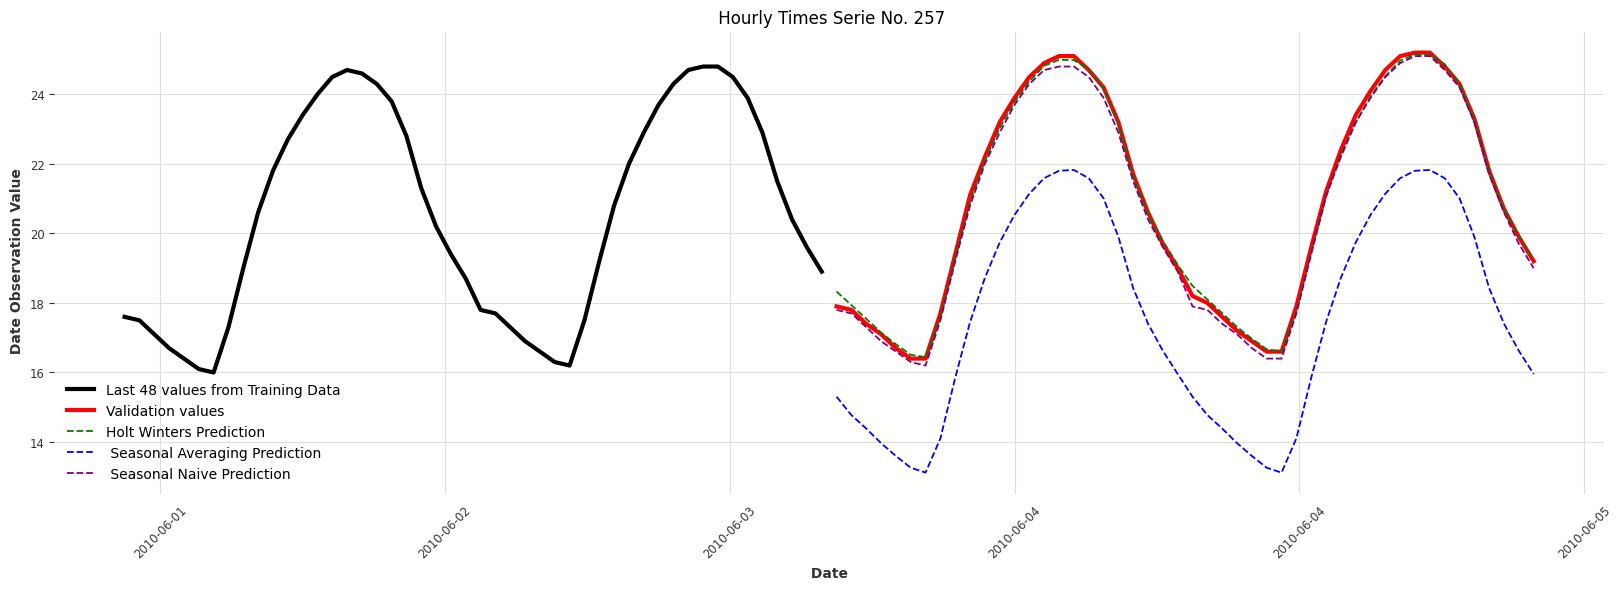

In [8]:
# Plotting the graph
plt.figure(figsize=(20, 6))

plt.plot(df.index[-h:], df[-h:], color='black', label= f'Last {h} values from Training Data', lw = 3 )
plt.plot(tested[:h].index, tested[:h], color='red', label = "Validation values", lw = 3)

# Holt Winters Predition
plt.plot(holt_winters_forecast.index, holt_winters_forecast, color='green', label = "Holt Winters Prediction", linestyle = "--")
# Seasonal Averaging Predition
plt.plot(sea_average_forecast.index, sea_average_forecast, color='blue', label = " Seasonal Averaging Prediction",  linestyle = "--")
# Seasonal Naive Predition
plt.plot(naive_forecast.index, naive_forecast, color='purple', label = " Seasonal Naive Prediction",  linestyle = "--")



plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation=45) 


plt.title(f" Hourly Times Serie No. {n}")
plt.xlabel(" Date ")
plt.ylabel(" Date Observation Value")

plt.legend()
plt.show()

### Calculating the sMAPE and MASE for the Models

In [9]:
# Calculate sMAPE for each forecast
smape_holt_winters = round(smape(tested[:h], holt_winters_forecast), 2)
smape_sea_average = round(smape(tested[:h], sea_average_forecast), 2)
smape_naive = round(smape(tested[:h], naive_forecast), 2)

# Calculate MASE for each forecast
mase_holt_winters = round(mase(df, tested[:h], holt_winters_forecast[:-2], 24), 2)
mase_sea_average = round(mase(df, tested[:h], sea_average_forecast[:-2], 24), 2)
mase_naive = round(mase(df, tested[:h], naive_forecast[:-2], 24), 2)

# Table of comparison
table = [
    ["Symmetric mean absolute percentage error (sMAPE)", f"{smape_holt_winters} %", f"{smape_sea_average} %", f"{smape_naive} %"],
    ["Mean Absolute Scaled Error (MASE)", mase_holt_winters, mase_sea_average, mase_naive]
]

# Print table
print(tabulate(table, headers=["Metric", "Holt-Winters", "Seasonal Average", "Naive"], tablefmt="simple"))


Metric                                            Holt-Winters    Seasonal Average    Naive
------------------------------------------------  --------------  ------------------  -------
Symmetric mean absolute percentage error (sMAPE)  0.51 %          17.69 %             0.88 %
Mean Absolute Scaled Error (MASE)                 0.68            21.46               1.16


### Using the Bayesian Model Averaging

In [10]:
from tabulate import tabulate

# Calculate sMAPE for each forecast
smape_holt_winters = smape(tested, holt_winters_forecast)
smape_sea_average = smape(tested, sea_average_forecast)
smape_naive = smape(tested, naive_forecast)

# Calculate MASE for each forecast
mase_holt_winters = mase(df, tested, holt_winters_forecast[:-2], seasonal_periods)
mase_sea_average = mase(df,  tested, sea_average_forecast[:-2], seasonal_periods)
mase_naive = mase(df,  tested, naive_forecast[:-2], seasonal_periods)

# Calculate inverse errors for weights (lower error -> higher weight)
inverse_errors = {
    'naive_forecast': 1 / smape_naive,
    'sea_average_forecast': 1 / smape_sea_average,
    'holt_winters_forecast': 1 / smape_holt_winters
}

# Calculate sum of inverse errors
sum_inverse_errors = sum(inverse_errors.values())

# Calculate weights
weights = {model: inverse_error / sum_inverse_errors for model, inverse_error in inverse_errors.items()}

# Combine forecasts using weights
bma_forecast = (
    weights['naive_forecast'] * naive_forecast +
    weights['sea_average_forecast'] * sea_average_forecast +
    weights['holt_winters_forecast'] * holt_winters_forecast
)

# Calculate error metrics for the combined forecast
smape_combined = smape( tested, bma_forecast)
mase_combined = mase(df, tested, bma_forecast[:-2], seasonal_periods)

# Table of comparison
table = [
    ["Symmetric mean absolute percentage error (sMAPE)", f"{smape_holt_winters:.2f} %", f"{smape_sea_average:.2f} %", f"{smape_naive:.2f} %", f"{smape_combined:.2f} %"],
    ["Mean Absolute Scaled Error (MASE)", mase_holt_winters, mase_sea_average, mase_naive, mase_combined]
]

# Print table
print(tabulate(table, headers=["Metric", "Holt-Winters", "Seasonal Average", "Naive", "Combined (BMA)"], tablefmt="simple"))
print(weights)

Metric                                            Holt-Winters        Seasonal Average    Naive               Combined (BMA)
------------------------------------------------  ------------------  ------------------  ------------------  ------------------
Symmetric mean absolute percentage error (sMAPE)  0.51 %              17.69 %             0.88 %              0.67 %
Mean Absolute Scaled Error (MASE)                 0.6841428797991301  21.459459216672656  1.1631333093783696  0.9274268045537857
{'naive_forecast': 0.35956652426287017, 'sea_average_forecast': 0.017910804132346275, 'holt_winters_forecast': 0.6225226716047836}


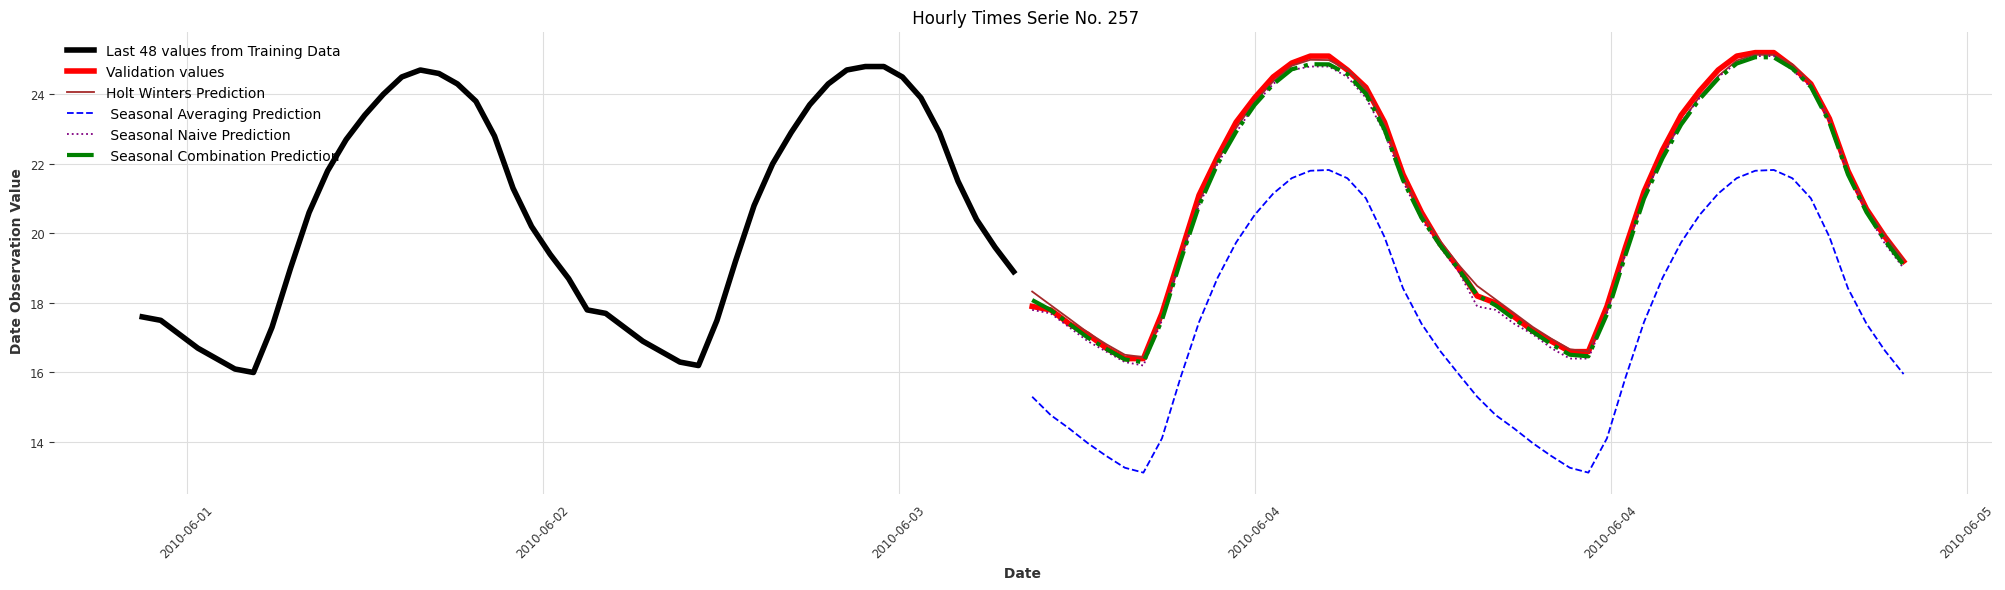

In [11]:
# Plotting the graph
plt.figure(figsize=(25, 6))

plt.plot(df.index[-h:], df[-h:], color='black', label= f'Last {h} values from Training Data',lw = 4)
plt.plot(tested.index, tested, color='red', label = "Validation values",lw = 4)

# Holt Winters Predition
plt.plot(holt_winters_forecast.index, holt_winters_forecast, color='brown', label = "Holt Winters Prediction", ls = "-")
# Seasonal Averaging Predition
plt.plot(sea_average_forecast.index, sea_average_forecast, color='blue', label = " Seasonal Averaging Prediction", ls = "--")
# Seasonal Naive Predition
plt.plot(naive_forecast.index, naive_forecast, color='purple', label = " Seasonal Naive Prediction", ls = ":")
# Forecast Combination Predition
plt.plot(bma_forecast.index, bma_forecast, color='green', label = " Seasonal Combination Prediction", ls = "-.",  lw = 3)


plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation=45) 


plt.title(f" Hourly Times Serie No. {n}")
plt.xlabel(" Date ")
plt.ylabel(" Date Observation Value")


plt.legend()
plt.show()

# Analysis of all Time Series in the Hourly Data Subset

In [12]:
# Initialize lists to store error metrics for each time series
smape_values = []
mase_values = []
owa_values = []

# Initialize list to store names of time series
time_series_names = []


# Loop through each time series in df
for n in range(1, len(df_train) + 1):
    # Dropping NA values and using only positive values
    df = df_train.iloc[n - 1, 2:].dropna()
    df = df[df > 0]
    df = pd.to_numeric(df, errors='coerce')

    # We use the initial value and set it to the first observation and then add an hour to next observations
    initial_date = df_train.iloc[n - 1, 0]
    index = pd.date_range(start=initial_date, periods=len(df), freq='h')
    df.index = index

    # Splitting into training and validation sets
    validation_size = 48  
    train_df = df.iloc[:-validation_size]  
    val_df = df.iloc[-validation_size:]  


    holt_winters_forecast = holt_winters(train_df, val_df, alpha= 0.1, beta= 0.1, gamma = 0.1, seasonal_periods= 24)
    sea_average_forecast = seasonal_averaging_forecast(train_df, val_df)  
    naive_forecast = seasonal_naive_forecast(df,val_df,24,48)

    # Calculate inverse errors for weights (lower error -> higher weight)
    inverse_errors = {
        'naive_forecast': 1 / smape_naive,
        'sea_average_forecast': 1 / smape_sea_average,
        'holt_winters_forecast': 1 / smape_holt_winters
    }

    # Calculate sum of inverse errors
    sum_inverse_errors = sum(inverse_errors.values())

    # Calculate weights
    weights = {model: inverse_error / sum_inverse_errors for model, inverse_error in inverse_errors.items()}

    # Combine forecasts using weights
    bma_forecast = (
        weights['naive_forecast'] * naive_forecast +
        weights['sea_average_forecast'] * sea_average_forecast +
        weights['holt_winters_forecast'] * holt_winters_forecast
    )

    # Calculate error metrics for the combined forecast
    smape_combined = smape(val_df, bma_forecast)
    mase_combined = mase(train_df, val_df, bma_forecast[:-2], seasonal_periods)

    # Calculate OWA
    owa_combined = 0.5 * (smape_combined / smape_naive + mase_combined / mase_naive)


    # Append error metrics to lists
    smape_values.append(smape_combined)
    mase_values.append(mase_combined)
    owa_values.append(owa_combined)


    # Append name of time series to list
    time_series_names.append("H" + str(n))

# Create matrix
error_matrix = np.column_stack((time_series_names, smape_values, mase_values, owa_values))

""" # Print matrix
print("Time Series | sMAPE (%) | MASE")
print("-----------------------------")
for row in error_matrix:
    print("{:<11} | {:>9.2f} | {:>5.2f}".format(row[0], float(row[1]), float(row[2])))
 """

# Calculate average error metrics
average_smape = sum(smape_values) / len(smape_values)
average_mase = sum(mase_values) / len(mase_values)
average_owa = sum(owa_values) / len(owa_values)

# Print average error metrics
print("Average Symmetric mean absolute percentage error (sMAPE): {:.2f}%".format(average_smape))
print("Average Mean Absolute Scaled Error (MASE): {:.2f}".format(average_mase))
print("Average Overall Weighted Average (OWA): {:.2f}".format(average_owa))

    

C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: Convergen

Average Symmetric mean absolute percentage error (sMAPE): 18.44%
Average Mean Absolute Scaled Error (MASE): 1.21
Average Overall Weighted Average (OWA): 10.99


C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [13]:
# Print error matrix using tabulate format
from tabulate import tabulate

# Create matrix
error_matrix = [["Time Series", "sMAPE (%)", "MASE","OWA"]]  # Header row
for n, smape, mase,owa in zip(time_series_names, smape_values, mase_values,owa_values):
    error_matrix.append([n, smape, mase,owa])

# Print matrix
print(tabulate(error_matrix, headers="firstrow", tablefmt="simple"))

Time Series      sMAPE (%)       MASE        OWA
-------------  -----------  ---------  ---------
H1               9.2153      1.46417    5.85983
H2               8.125       1.34388    5.18929
H3               6.27886     0.875085   3.93993
H4               4.68535     0.841472   3.02104
H5              10.5228      1.32858    6.54366
H6               3.26464     1.06935    2.31263
H7               6.66432     1.31324    4.34706
H8               6.92721     1.32171    4.49991
H9               6.33188     1.19789    4.10879
H10              1.96563     0.749283   1.43775
H11              7.04245     1.3283     4.56816
H12              8.61693     1.39096    5.48874
H13             17.7623      3.35229   11.5226
H14              5.10871     0.948905   3.30751
H15              5.21142     0.831429   3.31531
H16              8.00396     1.36001    5.12752
H17              3.39969     1.33682    2.50426
H18              2.13505     0.460026   1.40956
H19              2.86245     0.602469  

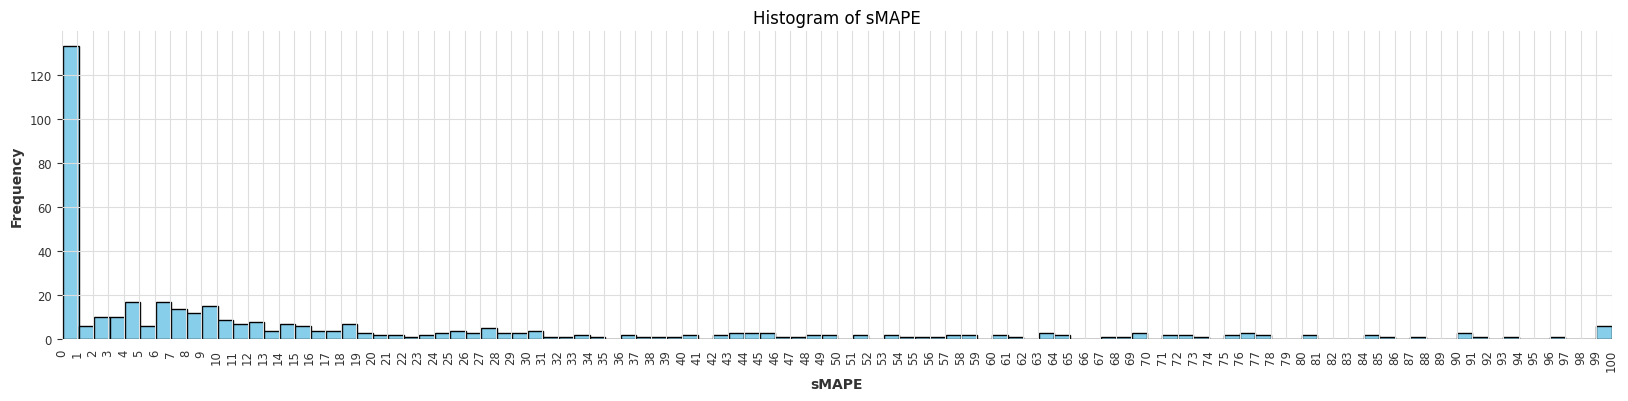

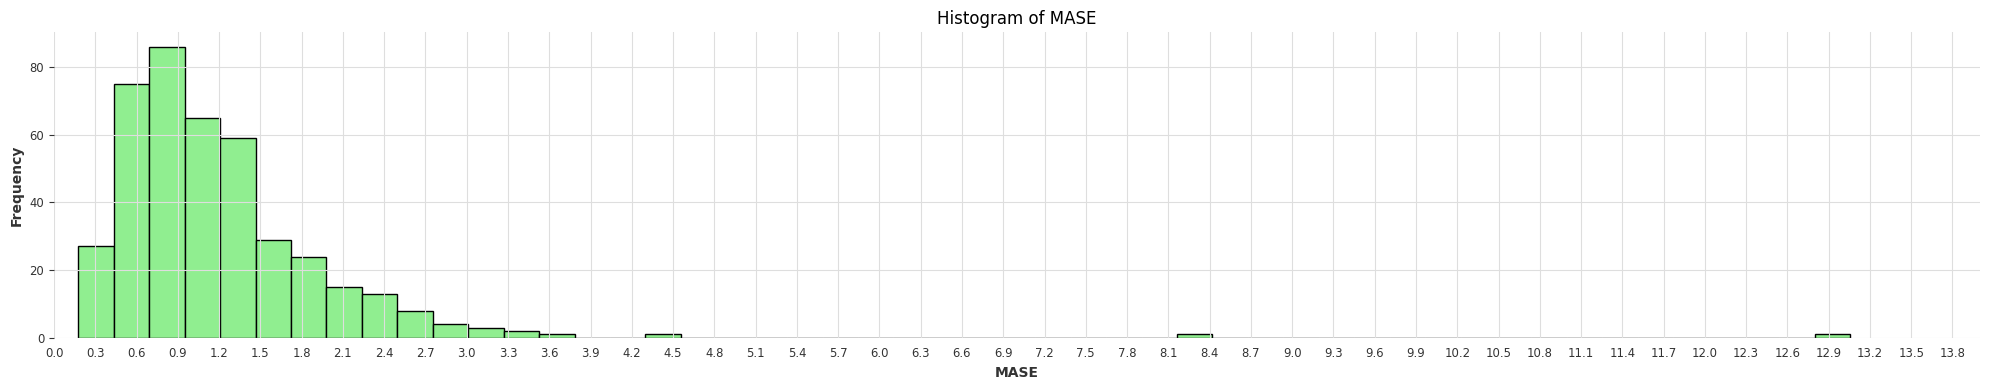

In [14]:
# Create histograms
plt.figure(figsize=(20, 4))
plt.hist(smape_values, bins=100, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(100))
plt.xticks(rotation=90) 
plt.title('Histogram of sMAPE')
plt.xlabel('sMAPE')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

plt.figure(figsize=(20, 4))
plt.hist(mase_values, bins=50, color='lightgreen', edgecolor='black')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(50))
plt.title('Histogram of MASE')
plt.xlabel('MASE')
plt.ylabel('Frequency')
plt.xlim(0, 14)
plt.tight_layout()
plt.show()